# The basic elements of an IMAGINE pipeline

In this tutorial, we focus on introducing the basic building blocks of the IMAGINE package and how to use them for assembling a Bayesian analysis pipeline.

We will use mock data with only two independent free parameters. First, we will generate the mock data. Then we will assemble all elements needed for the IMAGINE pipeline, execute the pipeline and investigate its results.

The mock data are designed to "naively" mimic Faraday depth, which is affected linearly by the (Galactic) magnetic field and thermal electron density. As a function of position $x$, we define a constant coherent magnetic field component $a_0$ and a random magnetic field component which is drawn from a Gaussian distribution with standard deviation $b_0$. The electron density is assumed to be independently known and given by a $\cos(x)$ with arbitrary scaling. 
The mock data values we get are related to the Faraday depth of a background source at some arbitrary distance: 

$$ signal(x) = \left[1+\cos(x)\right] \times \mathcal{G}(\mu=a_0,\sigma=b_0;seed=s)\,{\mu\rm G\,cm}^{-3} , \; x \in [0,2\pi]\,\rm kpc$$

where $\{a_0,b_0\}$ is the 'physical' parameter set, and $s$ represents the seed for random variable generation.



The purpose is not to fit the exact signal, since it includes a stochastic component, but to fit the amplitude of the signal and of the variations around it.  So this is fitting the strength of the coherent field $a_0$ and the amplitude of the random field $b_0$.  With these mock data and its (co)variance matrix, we shall assemble the IMAGINE pipeline, execute it and examine its results. 

First, import the necessary packages.

In [1]:
import numpy as np
import logging as log
from astropy.table import Table
from astropy import units as u
import corner
import matplotlib.pyplot as plt

import imagine as img

# call after importing matplotlib
%matplotlib inline

## 1) Preparing the mock data

In calculating the mock data values, we introduce noise as:

$$ data(x) = signal(x) + noise(x) $$

For simplicity, we propose a simple gaussian noise with mean zero and a standard deviation $e$:

$$ noise(x) = \mathcal{G}(\mu=0,\sigma=e) $$ .

We will assume that we have 10 points in the x-direction, in the range $[0, 2\pi]\,\rm kpc$.

In [2]:
a0 = 3. # true value of a
b0 = 6. # true value of b
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 10 # data size in measurements
x = np.linspace(0.01,2.*np.pi-0.01,size) # where the observer is looking at

np.random.seed(s) # set seed for signal field

signal = (1+np.cos(x)) * np.random.normal(loc=a0,scale=b0,size=size)

fd = signal + np.random.normal(loc=0.,scale=e,size=size)

# We load these to an astropy table for illustration/visualisation
data = Table({'meas' : fd, 
              'err': np.ones_like(fd)*e,
              'x': x,
              'y': np.zeros_like(fd),
              'z': np.zeros_like(fd),
              'other': np.ones_like(fd)*42
              })
data[:4] # Shows the first 4 points in tabular form

meas,err,x,y,z,other
float64,float64,float64,float64,float64,float64
16.4217790817552,0.1,0.01,0.0,0.0,42.0
7.172468731201507,0.1,0.7059094785755097,0.0,0.0,42.0
-3.2254947821460433,0.1,1.4018189571510193,0.0,0.0,42.0
0.27949334758966465,0.1,2.0977284357265287,0.0,0.0,42.0


These data need to be converted to an IMAGINE compatible format. To do this, we first create `TabularDataset` object, 
which helps importing dictionary-like dataset onto IMAGINE.   

In [3]:
import astropy.units as u
fd_units = u.microgauss*u.cm**-3

mockDataset = img.dataset.TabularDataset(data, name='test', 
                                         data_column='meas', 
                                         coordinates_type='cartesian',
                                         x_column='x', y_column='y', 
                                         z_column='z', error_column='err',
                                         units=fd_units)

These lines simply explain how to read the tabular dataset (note that the 'other' column is ignored): `name` contains the type of observable we are using (here, we use 'test', it could also be 'sync' for synchrotron observables (e.g, Stokes parameters), 'fd' for Faraday Depth, etc. The `data_column` argument specifies the key or name of the column containing the relevant measurement. Coordinates can be either `cartesian` as in this example, which requires specifying columns for $x$, $y$ and $z$ in $\rm kpc$, or  `galactic`, which requires setting the arguments `lat_column` and `lon_column` both in degrees.
The units of the dataset are represented using [astropy.units](https://docs.astropy.org/en/stable/units/) objects and must be supplied (the Simulator will later check whether these are adequate and automatically convert the data to other units if needed).


The dataset can be loaded onto `Measurements` and `Covariances` object, which are subclasses of `ObservableDict`. These objects allow one to supply multiple datasets to the pipeline.

In [4]:
mock_data = img.Measurements() # create empty Measrurements object
mock_data.append(dataset=mockDataset)

mock_cov = img.Covariances() # create empty Covariance object
mock_cov.append(dataset=mockDataset)

The dataset object creates a standard key for each appended dataset. In our case, there is only one key.

In [5]:
keys = list(mock_data.keys())
keys

[('test', 'nan', 'tab', 'nan')]

Let us plot the mock data as well as the $1+\cos(x)$ function that is the underlying variation.  

The property `Measurements.global_data` extracts arrays from the `Observable` object which is hosted inside the `ObservableDict` class. 

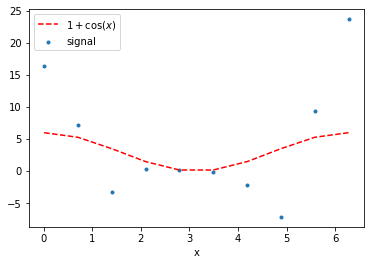

In [6]:
plt.scatter(x, mock_data[keys[0]].global_data[0], marker='.', label='signal')
plt.plot(x,(1+np.cos(x))*a0,'r--',label='$1+\cos(x)$')
plt.xlabel('x'); plt.legend();

Note that the variance in the signal is highest where the $\cos(x)$ is also strongest. This is the way we expect the Faraday depth to work, since a fluctuation in the strength of $\mathbf B$ has a larger effect on the RM when $n_e$ also happens to be higher. 

## 2) Pipeline assembly

Now that we have generated mock data, there are a few steps to set up the pipeline to estimate the input parameters.  We need to specify: a grid, Field Factories, Simulators, and Likelihoods.

### Setting the coordinate grid

Fields in IMAGINE represent models of any kind of physical field -- in this particular tutorial, we will need a magnetic field and thermal electron density. 

The Fields are evaluated on a grid of coordinates, represented by a `img.Grid` object. Here we exemplify how to produce a *regular cartesian* grid. To do so, we need to specify the values of the coordinates on the 6 extremities of the box (i.e. the minimum and maximum value for each coordinate), and the resolution over each dimension.  

For this particular artificial example, we actually only need one dimension, 
so we set the resolution to 1 for $y$ and $z$. 

In [7]:
one_d_grid = img.UniformGrid(box=[[0,2*np.pi]*u.kpc,
                                  [0,0]*u.kpc,
                                  [0,0]*u.kpc],
                             resolution=[30,1,1])

### Preparing the Field Factories

A particular realisation of a model for a physical field is represented within IMAGINE by a *Field* object, which, given set of parameters, evaluates the field for over the grid.  

A *Field Factory* is an associated piece of infrastructure used by the Pipeline to produce new Fields. It is a Factory object that needs to be initialized and supplied to the Pipeline. This is what we will illustrate here. 


In [8]:
import imagine.fields.test_field as testFields
ne_factory = testFields.CosThermalElectronDensity_Factory(grid=one_d_grid)

The previous line instantiates `CosThermalElectronDensity_Factory` with the previously defined Grid object. This Factory allows the Pipeline to produce
`CosThermalElectronDensity` objects. These correspond to a toy model for electron density with the form: 
$$n_e(x,y,z) = n_0 [1+\cos (a x + \alpha)][1+\cos (b y + \beta)][1+\cos(c y + \gamma)]\,. $$ 

We can set and check the default parameter values in the following way:

In [9]:
ne_factory.default_parameters= {'a': 1*u.rad/u.kpc,
                                'beta':  np.pi/2*u.rad, 
                                'gamma': np.pi/2*u.rad}
ne_factory.default_parameters

{'n0': <Quantity 1. 1 / cm3>,
 'a': <Quantity 1. rad / kpc>,
 'b': <Quantity 0. rad / kpc>,
 'c': <Quantity 0. rad / kpc>,
 'alpha': <Quantity 0. rad>,
 'beta': <Quantity 1.57079633 rad>,
 'gamma': <Quantity 1.57079633 rad>}

In [10]:
ne_factory.active_parameters

()

For `ne_factory`, no active parameters were set. This means that the Field will be always evaluated using the specified default parameter values.

We will now similarly define the magnetic field, using the `NaiveGaussianMagneticField` which constructs a "naive" random field (i.e. the magnitude of $x$, $y$ and $z$ components of the field are drawn from a Gaussian distribution **without** imposing *zero divergence*, thus *do not use this for serious applications*).

In [11]:
B_factory = testFields.NaiveGaussianMagneticField_Factory(grid=one_d_grid)

Differently from the case of `ne_factory`, in this case we would like to make the parameters active. All individual components of the field are drawn from a Gaussian distribution with mean $a_0$ and standard deviation $b_0$. To set these parameters as active we do:

In [12]:
B_factory.active_parameters = ('a0','b0')
B_factory.priors ={'a0': img.FlatPrior(interval=[-5,5]*u.microgauss),
                   'b0': img.FlatPrior(interval=[0,10]*u.microgauss)}

In the lines above we chose uniform (flat) priors for both parameters within the above specified ranges. Any active parameter must have a Prior distribution specified.

Once the two FieldFactory objects are prepared, they put together in a list which is later supplied to the Pipeline.

In [13]:
factory_list = [ne_factory, B_factory]

3) Simulators: For this tutorial, we use a customized TestSimulator which simply computes the quantity: $t(x,y,z) = B_y\,n_e\,$,i.e. the contribution at one specific point to the Faraday depth.

The simulator is inialized with the mock Measurements defined before, which allows it to know what is the correct format for output.

In [14]:
from imagine.simulators.test_simulator import TestSimulator
simer = TestSimulator(mock_data)

4) Likelihoods: IMAGINE provides the `Likelihood` class with `EnsembleLikelihood` and `SimpleLikelihood` as two options.  The `SimpleLikelihood` is what you expect, computing a single $\chi^2$ from the difference of the simulated and the measured datasets.  The `EnsembleLikelihood` is how IMAGINE handles a signal which itself includes a stochastic component, e.g., what we call the Galactic variance.  This likelihood module makes use of a finite ensemble of simulated realizations and uses their mean and covariance to compare them to the measured dataset.  

In [15]:
likelihood = img.EnsembleLikelihood(mock_data, mock_cov) # initialize likelihood with measured info

## 3) Running the pipeline

Now we have all the necessary component available to run our pipeline. This can be done through a `Pipeline` object, which interfaces with some algorithm to sample the likelihood space accounting for the prescribed prior distributions for the parameters. 

IMAGINE comes with a range of different samplers, all of them are based on the nested sampling approach. In what follows we will discuss some of them.

### UltraNest

We will first illustrate the using the UltraNest sampler. 

In [16]:
## Generate 200 realizations at each sample
ensemble_size = 200
## Define the pipeline using the UltraNest sampler, giving it the required elements
pipe = img.UltranestPipeline(simer, factory_list, likelihood, ensemble_size)
## Set its random seed with a positive integer, or 0 to start randomly from the system clock.  
pipe.random_type = 'free'
## Set some controller parameters that are specific to UltraNest.  
pipe.sampling_controllers = {'max_ncalls': 500,
                             'min_num_live_points': 100}

In [17]:
# Runs IMAGINE pipeline!
results = pipe()

[ultranest] Sampling 100 live points from prior ...


INFO:ultranest:Sampling 100 live points from prior ...
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 100.0), (inf, 100.0)]


DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([99,  1]))


[ultranest] Explored until L=-3e+01   [-6265.5239..-30.7482] | it/evals=252/502 eff=62.6866% N=100 


INFO:ultranest:Explored until L=-3e+01  


[ultranest] Likelihood function evaluations: 502


INFO:ultranest:Likelihood function evaluations: 502
DEBUG:ultranest:did a run_iter pass!


[ultranest] Reached maximum number of likelihood calls (502 > 500)...


INFO:ultranest:Reached maximum number of likelihood calls (502 > 500)...


[ultranest] done iterating.


INFO:ultranest:done iterating.


When one runs the pipeline it returns a results dictionary object in the native format of the chosen sampler.

After running the pipeline object, the results can also be access through its attributes, which are standard interfaces. For example, a table containing the parameter values of the samples generated can be accessed through

In [18]:
samp = pipe.samples
samp[:3]

naive_gaussian_magnetic_field_a0,naive_gaussian_magnetic_field_b0
uG,uG
float64,float64
2.6450892872674423,4.9284226481002955
2.659237535368809,7.266287304829952
4.402096893547673,7.507648618863519


The distributions of samples approximate the posterior distribution, below this is plotted with the help of the `corner` library, whcih also shows the best-fit values and $1\sigma$ and $2\sigma$ contours.

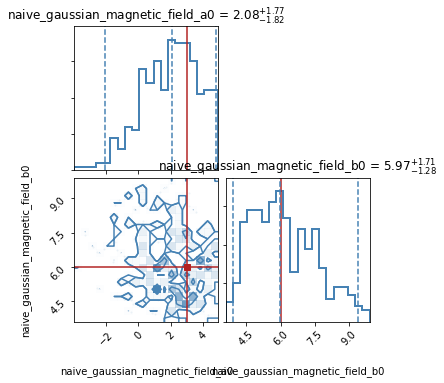

In [19]:
##  See https://corner.readthedocs.io/en/latest/pages/sigmas.html about contour levels.  
##  "Contours are shown at 0.5, 1, 1.5, and 2 sigma" by default
##  according to https://pypi.org/project/corner/1.0.1/, but I want 1, 2, and 3.
sigmas=np.array([1.,2.,3.])
levels=1-np.exp(-0.5*sigmas*sigmas)

# Visualize with a corner plot
figure = corner.corner(np.vstack([samp.columns[0].value, samp.columns[1].value]).T,
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 12},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 10},
                       levels=levels)

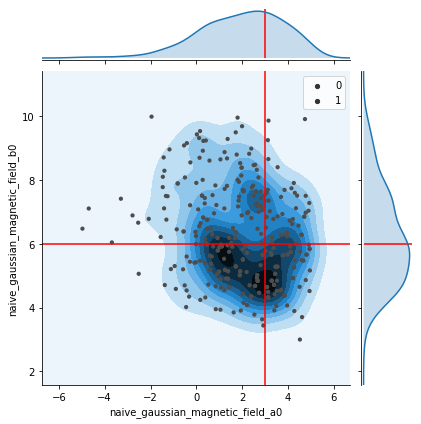

In [20]:
def show_truth_in_jointplot(jointplot, true_x, true_y, color='r'):
    for ax in (jointplot.ax_joint, jointplot.ax_marg_x):
        ax.vlines([true_x], *ax.get_ylim(), colors=color)
    for ax in (jointplot.ax_joint, jointplot.ax_marg_y):
        ax.hlines([true_y], *ax.get_xlim(), colors=color)

import seaborn as sns
snsfig = sns.jointplot(*samp.colnames, data=samp.to_pandas(), kind='kde')
snsfig.plot_joint(sns.scatterplot, linewidth=0, size=1, color='0.3')
show_truth_in_jointplot(snsfig, a0, b0)

For comparing different models, the quantity of interest *model evidence* or *marginal likelihood*. After a run, this can be easily accessed as follows.

In [21]:
print('log evidence:', pipe.log_evidence)
print('log evidence error:', pipe.log_evidence_err)

log evidence: -32.36258298658139
log evidence error: 0.4361144063669201


### Multinest


In [ ]:
## Generate 250 realizations at each sample
ensemble_size = 250 
## Define the pipeline using the MultiNest sampler, giving it the required elements
pipe_multinest = img.MultinestPipeline(simer, factory_list, likelihood, ensemble_size)
## Set its random seed with a positive integer, or 0 to start randomly from the system clock.  
pipe_multinest.random_type = 'free'
## Set some controller parameters that are specific to pyMultiNest.  
pipe_multinest.sampling_controllers = {'n_iter_before_update': 1,
                             'n_live_points': 100,
                             'evidence_tolerance': 0.1,
                             'verbose': True,
                             'resume': False}

In [ ]:
results = pipe_multinest()

/home/lfsr/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2537: RuntimeWarning: invalid value encountered in true_divide
  (grid[i + 1] - grid[i]))
/home/lfsr/anaconda3/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:2520: RuntimeWarning: invalid value encountered in less_equal
  for i, yi in zip(indices, norm_distances)]


Now we can look at the results, which consist of a set of sampled points in the likelihood space.  

In [ ]:
from imagine.tools.carrier_mapper import unity_mapper
# samples = results['samples']  # load sample points
scaled_samples = np.empty_like(samples)

## convert from pipeline-internal (0-1) values into physical parameters
for i, param in enumerate(pipe.active_parameters): 
    low, high = pipe.active_ranges[param]
    for j, sample in enumerate(samples[:,i]):
        scaled_samples[j,i] = unity_mapper(sample, low, high)

##  See https://corner.readthedocs.io/en/latest/pages/sigmas.html about contour levels.  
##  "Contours are shown at 0.5, 1, 1.5, and 2 sigma" by default
##  according to https://pypi.org/project/corner/1.0.1/, but I want 1, 2, and 3.
sigmas=np.array([1.,2.,3.])
levels=1-np.exp(-0.5*sigmas*sigmas)

# Visualize with a corner plot
figure = corner.corner(scaled_samples[:, :],
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15},
                       levels=levels)

### Dynesty

Now, use the Dynesty sampler instead of MultiNest.
The only difference at the frontend is the sampler-dependent
controlling parameters. 
One advantage of Dynesty is that it provides an informative 
progress bar under the cell executing it, as you can see.

In [ ]:
from imagine.pipelines.dynesty_pipeline import DynestyPipeline
from imagine.tools.carrier_mapper import unity_mapper

pipe_dynesty = DynestyPipeline(simer, factory_list,
                               likelihood, ensemble_size)
pipe_dynesty.random_type = 'free'
pipe_dynesty.sampling_controllers = {'dlogz':'0.1'} 

results_dynesty = pipe_dynesty(dynamic=True, maxcall=500, 
                               nlive_init=50, nlive_batch=2)

In [ ]:
a = np.array([weights, weights]) # samples.shape
a.T.shape, samples.shape

In [ ]:
samples = results_dynesty['samples'].copy()
weights = np.exp(results_dynesty['logwt'])

for i, param in enumerate(pipe_dynesty.active_parameters): 
    low, high = pipe_dynesty.active_ranges[param]
    for j, sample in enumerate(samples[:,i]):
        samples[j, i] = unity_mapper(sample, low, high)
# corner plot
figure = corner.corner(samples[:, :len(pipe_dynesty.active_parameters)],
                       weights=weights,
                       range=[0.99]*len(pipe_dynesty.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe_dynesty.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

In [ ]:
samples = results_dynesty['samples'].copy()

for i, param in enumerate(pipe_dynesty.active_parameters): 
    low, high = pipe_dynesty.active_ranges[param]
    for j, sample in enumerate(samples[:,i]):
        samples[j, i] = unity_mapper(sample, low, high)
# corner plot
figure = corner.corner(samples[:, :len(pipe_dynesty.active_parameters)],
                       range=[0.99]*len(pipe_dynesty.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe_dynesty.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

In [ ]:
from dynesty import plotting as dyplot
dyplot.cornerplot(results_dynesty, color='steelblue',truths=[a0,b0]);

## Addendum: a simple convergence check

The mock data was generated with a fixed random seed, while in the Bayesian analysis time-thread dependent seeds are adopted. Therefore, it is interesting to check if different executions are consistent.  In other words, when you start the sampler at different places, does it always converge on the same region of parameter space?  Let's see what happens when we run it five times and just overplot histograms of the outputs to see if they all look the same.  There are more rigorous tests, of course, that we have done, but they take longer.  This can be done in a few minutes:

In [ ]:
from scipy.stats import norm
repeat = 3

for i in range(repeat):
    tmp = pipe(max_ncalls=150, min_num_live_points=50)
    
    for i, param in enumerate(pipe.active_parameters): 
    low, high = pipe.active_ranges[param]
        for j, sample in enumerate(samples[:,i]):
            scaled_samples[j,i] = unity_mapper(sample, low, high)

    
    
    asamp = tmp['samples'][:,0]
    bsamp = tmp['samples'][:,1]
    plt.hist(asamp, 30, histtype='step', stacked=True, 
             fill=True, color='firebrick', alpha=0.1)
    plt.hist(bsamp, 30, histtype='step', stacked=True,
             fill=True,label='b',color='steelblue',alpha=0.1)

### This ends tutorial 1. 

The python script for tutorial 1 can be found in [li_multinest](https://github.com/IMAGINE-Consortium/imagine/blob/mpi/examples/test_examples/lisimulator_multinest.py) and [li_dynesty](https://github.com/IMAGINE-Consortium/imagine/blob/mpi/examples/test_examples/lisimulator_dynesty.py)
